
# IndabaX Hackathon Advanced Challenge.

Welcome to the Locust Breeding Ground Prediction Hackathon! This event brings together passionate individuals to develop innovative solutions to mitigate the devastating effects of desert locust swarms.

**Hackathon Theme:** Using advanced machine learning techniques and multispectral satellite imagery to predict locust breeding grounds.

## Problem Description

Desert locusts (Schistocerca gregaria) are a species of short-horned grasshoppers known for
their ability to form large, devastating swarms. They are found primarily in the deserts of Africa,
the Middle East, and South Asia. They pose a significant threat to food security in Africa and are
known to be the world’s most destructive pests.
As described in the beginner version, our strategy towards mitigating the devastating effects of
desert locusts swarms is to identify their breeding grounds in order for control activities to be
carried out by the relevant agencies.

The locust breeding ground dataset in this challenge was
curated by sourcing locust observations from the United Nations (UN) Food and Agricultural
Organization (FAO) [Locust Hub](https://locust-hub-hqfao.hub.arcgis.com/). But unlike in the beginner version, here we use multispectral
earth observation imagery from Sentinel-2 and Landsat-8 satellites. The images from both
satellites have been harmonized and made available by[NASA's Harmonized Landsat and
Sentinel-2 (HLS)](https://https://hls.gsfc.nasa.gov/) project.

##Objective

Develop a machine learning model to predict locust breeding grounds using the provided preprocessed HLS Satellite dataset. The dataset contains temporal image data with six spectral bands and is labelled with corresponding segmentation maps.

The segmentation maps are 2D images corresponding pixel-to-pixel with the area visualised by the input satellite images. Each pixel is a boolean indicating whether the region in the pixel is predicted to be a locust breeding ground.

All notebook submissions should be made on Zindi, which will rank submissions based on accuracy, F1-score, and other metrics.

##Datasets

* Preprocessed HLS data containing 6 spectral bands (Blue, Green, Red, NIR Narrow, SWIR1, SWIR2) over three temporal steps.
* Segmentation maps with binary labels.

## Support Channels
* SwapCard Hackathon Discussion Forum

## Mentor and Support
* Shane Action
* Ruan De Kock
* Jeroen Van Goey
* Refiloe Shabe
* Divanisha Patel
* Siddarth Singh

## Submission Process

The error metric for this competition is Intersection over Union (IoU).

For every image in the dataset, a corresponding segmentation map should be produced.

Your predicted segmentation maps will be evaluated against the ground truth using IoU.

Below you can see a dipiction of IoU, which measures the predicted accuracy the model predictions.


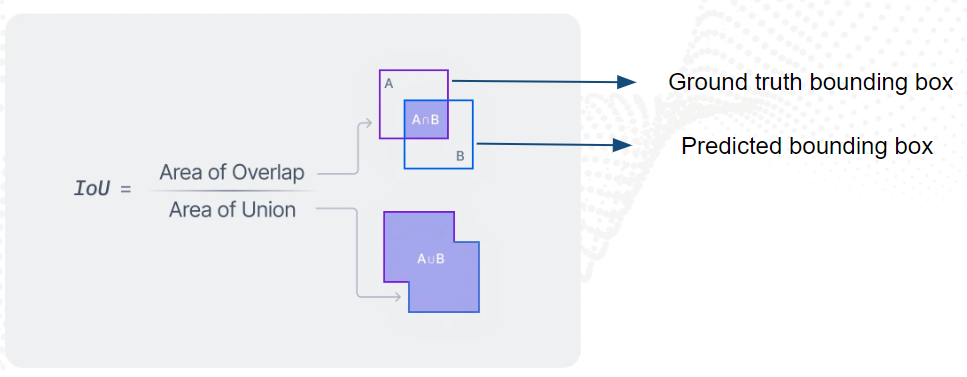

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

In [ ]:
cd drive/Shareddrives/IndabaX\ 2024/Hackathon/Hackathon\ Problems/Instadeep/Advanced\ Hackathon/hackathon\ - advance data/

In [ ]:
!ls

In [ ]:
!pip install rasterio xarray numpy pandas torch torchvision Pillow Absl-py

For this challenge, you will get preprocessed HLS data for locust breeding ground prediction.
The dataset contains a temporal image data with shape 18 x 224 x 224. This data contains 6
spectral bands (Blue, Green, Red, NIR Narrow, SWIR1, SWIR2) with three temporal steps. The
label is a segmentation map of shape 2 x 256 x 256, where each pixel with valid data contains a
binary label.

In [ ]:
import os
import random
from functools import partial
from pathlib import Path

import rasterio
import xarray as xr

import numpy as np
import pandas as pd
import rasterio
from absl import logging
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset

In [ ]:
batch_size = 8
root_dir = Path("data/") # TO DO: Fix
valid_filepath = root_dir/"val.csv"
train_filepath = root_dir/"train.csv"
test_filepath = root_dir/"test.csv"

IM_SIZE = 224
TEMPORAL_SIZE = 3

In [ ]:
def open_mf_tiff_dataset(band_files):
    band_paths = list(band_files["tiles"].values())
    bands_dataset = xr.open_mfdataset(
        band_paths,
        concat_dim="band",
        combine="nested",
    )
    with rasterio.open(band_paths[0]) as src:
        crs = src.crs
    return bands_dataset, crs

In [ ]:
def random_crop_and_flip(ims, label, im_size):
  """

  """
  i, j, h, w = transforms.RandomCrop.get_params(ims[0], (im_size, im_size))

  ims = [transforms.functional.crop(im, i, j, h, w) for im in ims]
  label = transforms.functional.crop(label, i, j, h, w)

  if random.random() > 0.5:
      ims = [transforms.functional.hflip(im) for im in ims]
      label = transforms.functional.hflip(label)

  if random.random() > 0.5:
      ims = [transforms.functional.vflip(im) for im in ims]
      label = transforms.functional.vflip(label)

  return ims, label


def normalize_and_convert_to_tensor(
    ims,
    label,
    mean,
    std,
    temporal_size,
):
  '''

  '''
  norm = transforms.Normalize(mean, std)
  ims_tensor = torch.stack([transforms.ToTensor()(im).squeeze() for im in ims])
  _, h, w = ims_tensor.shape
  if label:
      label = torch.from_numpy(np.array(label)).squeeze()
  return ims_tensor, label


def process_and_augment(
    x,
    y,
    mean,
    std,
    temporal_size=1,
    im_size=224,
    train=True,
):
  '''

  '''
  ims = x.copy()
  label = None
  ims = [Image.fromarray(im) for im in ims]
  if not (y is None):
      label = y.copy()
      label = Image.fromarray(label.squeeze())
  if train:
      ims, label = random_crop_and_flip(ims, label, im_size)
  ims, label = normalize_and_convert_to_tensor(ims, label, mean, std, temporal_size)
  return ims, label.to(torch.long)


def crop_array(arr, left, top, right, bottom):
    if len(arr.shape) == 2:
        return arr[top:bottom, left:right]
    elif len(arr.shape) == 3:
        return arr[:, top:bottom, left:right]
    elif len(arr.shape) == 4:
        return arr[:, :, top:bottom, left:right]
    else:
        raise ValueError("Input array must be a 2D, 3D or 4D array")


def process_test(
    x,
    y,
    mean,
    std,
    temporal_size,
    img_size,
    crop_size,
    stride,
):
    """Process and augment test data."""
    preprocess_func = partial(
        process_and_augment,
        mean=mean,
        std=std,
        temporal_size=temporal_size,
        train=False,
    )

    img_crops, mask_crops = [], []
    width, height = img_size, img_size

    for top in range(0, height - crop_size + 1, stride):
        for left in range(0, width - crop_size + 1, stride):
            bottom = top + crop_size
            right = left + crop_size

            img_crops.append(crop_array(x, left, top, right, bottom))
            mask_crops.append(crop_array(y, left, top, right, bottom))

    samples = [preprocess_func(x, y) for x, y in zip(img_crops, mask_crops)]
    imgs = torch.stack([sample[0] for sample in samples])
    labels = torch.stack([sample[1] for sample in samples])
    return imgs, labels


def get_raster_data(
    fname,
    is_label: bool = True,
    bands= None,
) -> np.ndarray:
    if isinstance(fname, dict):
        data, _ = open_mf_tiff_dataset(fname)
        data = data.fillna(-1)
        data = data.band_data.values
    else:
        with rasterio.open(fname) as src:
            data = src.read()
    if (not is_label) and bands:
        data = data[bands, ...]
    # For some reasons, some few HLS tiles are not scaled. In the following lines,
    # we find and scale them
    bands = []
    for band in data:
        if band.max() > 10:
            band *= 0.0001
        bands.append(band)
    data = np.stack(bands, axis=0)
    return data


def process_data(
    im_fname,
    mask_fname,
    bands= None,
    constant_multiplier= 1.0,
    mask_cloud= False,
    fix_scaling= True,
):
    arr_x = get_raster_data(
        im_fname,
        is_label=False,
        bands=bands,
    )
    arr_x = np.where(arr_x == -1, 0, arr_x).astype(np.float32)
    if mask_fname:
        arr_y = get_raster_data(mask_fname)
        arr_y = np.where(arr_y == -1, -100, arr_y)
    else:
        arr_y = None
    return arr_x, arr_y


def load_data_from_csv(fname, input_root):
    file_paths = []
    data = pd.read_csv(fname)
    for _, row in data.iterrows():
        im_path = os.path.join(input_root, row["Input"])
        mask_path = os.path.join(input_root, row["Label"])
        if os.path.exists(im_path):
            try:
                with rasterio.open(im_path) as src:
                    _ = src.crs
                file_paths.append((im_path, mask_path))
            except Exception as e:
                logging.error(e)
                continue
    return file_paths

In [ ]:
class InstaGeoDataset(torch.utils.data.Dataset):
    """InstaGeo PyTorch Dataset for Loading and Handling HLS Data."""

    def __init__(
        self,
        filename,
        input_root,
        preprocess_func,
        bands= None,
    ):
        self.input_root = input_root
        self.preprocess_func = preprocess_func
        self.bands = bands
        self.file_paths = load_data_from_csv(filename, input_root)

    def __getitem__(self, i: int):
        im_fname, mask_fname = self.file_paths[i]
        arr_x, arr_y = process_data(
            im_fname,
            mask_fname,
            bands=self.bands,
        )
        return self.preprocess_func(arr_x, arr_y)

    def __len__(self) -> int:
        return len(self.file_paths)


In [ ]:
!ls

In [ ]:
cd ..

In [ ]:
BANDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

train_ds_sample = InstaGeoDataset(
    filename=train_filepath,
    input_root=root_dir,
    preprocess_func=lambda x, y: (x, y),
    bands=BANDS,
)

val_ds_sample = InstaGeoDataset(
    filename=valid_filepath,
    input_root=root_dir,
    preprocess_func=lambda x, y: (x, y),
    bands=BANDS,
)

test_ds_sample = InstaGeoDataset(
    filename=test_filepath,
    input_root=root_dir,
    preprocess_func=lambda x, y: (x, y),
    bands=BANDS,
)
concatenated_dataset = ConcatDataset([train_ds_sample, val_ds_sample, test_ds_sample])
statistics_dataloader = DataLoader(concatenated_dataset, batch_size=8, shuffle=False)

In [ ]:


def compute_mean_std(dataloader: DataLoader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in dataloader:
        images = images.view([batch_size*3, 6, -1])
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images.size(0)

    mean /= total_images_count
    std /= total_images_count

    return mean.numpy(), std.numpy()

MEAN, STD = compute_mean_std(statistics_dataloader)
print("Mean:", MEAN)
print("Std:", STD)


In [ ]:
"""
Load datasets in
"""

train_dataset = InstaGeoDataset(
    filename=train_filepath,
    input_root=root_dir,
    preprocess_func=partial(
        process_and_augment,
        mean=MEAN,
        std=STD,
        temporal_size=TEMPORAL_SIZE,
        im_size=IM_SIZE,
    ),
    bands=BANDS,
)

valid_dataset = InstaGeoDataset(
    filename=valid_filepath,
    input_root=root_dir,
    preprocess_func=partial(
        process_and_augment,
        mean=MEAN,
        std=STD,
        temporal_size=TEMPORAL_SIZE,
        im_size=IM_SIZE,
    ),
    bands=BANDS,
)

test_dataset = InstaGeoDataset(
    filename=test_filepath,
    input_root=root_dir,
    preprocess_func=partial(
        process_test,
        mean=MEAN,
        std=STD,
        temporal_size=TEMPORAL_SIZE,
        img_size=IM_SIZE,
        crop_size=224,
        stride=224,
    ),
    bands=BANDS,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: (
                torch.cat([a[0] for a in x], 0),
                torch.cat([a[1] for a in x], 0),
            ),)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SegmentationModel(nn.Module):
    def __init__(self, in_channels=18, out_channels=1):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.squeeze()

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

    return model

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    running_count = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            no_ignore = labels.ne(-100).to(device)
            preds = preds.masked_select(no_ignore).cpu().numpy()
            gt = labels.masked_select(no_ignore).cpu().numpy()
            loss = criterion(outputs, labels.squeeze())

            running_loss += loss.item() * inputs.size(0)
            running_correct += np.sum(preds == gt)
            running_count += gt.size

    overall_accuracy = running_correct / running_count
    total_loss = running_loss / len(dataloader.dataset)
    print(f'Loss: {total_loss:.4f}')
    print(f'Accuracy: {overall_accuracy:.4f}')

### model training draft

In [ ]:
def cnn_baseline(X_train, X_val, y_train, y_val, data_shape, no_of_classes=8, iters = 20):
    model= Sequential()


    #convolution layer
    model.add(Conv1D(32, 3, padding='same', activation='relu', input_shape = data_shape))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #pooling layer
    model.add(Conv1D(64, 3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv1D(64, 3, padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    #fully connected layer
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    #output layer
    model.add(Dense(no_of_classes, activation='softmax'))

    #Model Compilation
    model.compile(optimizer = keras.optimizers.Adam(lr=0.001, epsilon=1e-07, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    #Baseline Model Architecture
    keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

    #Baseline Model Architecture Information
    print(model.summary())



    model_hist = model.fit(X_train, y_train, epochs=iters, validation_data = (X_val, y_val))

    return model_hist, model

In [ ]:
#mel_model
shape = X_train.shape[1:]

hist, model = cnn_baseline(X_train, X_val, y_train, y_val, shape)

In [ ]:
keras.utils.plot_model(df_model, to_file='Baseline_Model.png', show_shapes=True, show_layer_names=True)

In [ ]:
cls_y_val = np.argmax(en_y_val, axis=1)
cls_y_val = cls_y_val.reshape(en_y_val.shape[0],1)
predictions = df_model.predict(tf_X_val)
cls_y_pred = np.argmax(predictions, axis=1)
cls_y_pred = cls_y_pred.reshape(cls_y_pred.shape[0],1)

print(cls_y_pred.shape)
print(cls_y_val.shape)

In [ ]:
cm=confusion_matrix(cls_y_val, cls_y_pred)

index = []
columns = []

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig('baseline confusion matrix.png', dpi=600)
plt.show()

In [ ]:
plt = plot_train(df_hist.history)
plt.savefig('all_prediction_graph.png', dpi=600)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:

print(classification_report(cls_y_val, cls_y_pred))

In [ ]:
path = os.getcwd()

model_name = 'Prediction_Model.h5'
save_dir = os.path.join(path, 'models')

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)

In [ ]:

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
cost_eval, acc_eval = df_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))

##hyper parameter tuning

In [ ]:
class Hyper_Emotion_Pred(HyperModel):

    def __init__(self, data_shape, no_of_classes=8):
        self.data_shape = data_shape
        self.no_of_classes = no_of_classes


    def build(self, hyper):

        model= Sequential()

        #convolution layer
        model.add(Conv1D(filters = hyper.Choice('Conv_Filters_1',values=[64, 128, 256], default=64),
                         kernel_size = 5,
                         input_shape = self.data_shape))
        model.add(Conv1D(filters = hyper.Choice('Conv_Filters_1',values=[64, 128, 256], default=64),
                         kernel_size = 3,
                         activation = hyper.Choice('Conv_Activation_1', values=['relu', 'sigmoid'], default='relu')))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate = hyper.Float('Dropout_Rate_1', min_value=0.0, max_value=0.5, default=0.25,step=0.05)))

        model.add(Conv1D(filters=hyper.Choice('Conv_Filters_1',values=[16, 32, 64],default=16),activation='relu',kernel_size=3, input_shape=self.data_shape))
        model.add(Conv1D(filters=hyper.Choice('Conv_Filters_1',values=[16, 32, 64],default=16), activation=hyper.Choice('Conv_Activation_2',values=['relu', 'sigmoid'],default='relu'),kernel_size=3))
        model.add(Dropout(rate=hyper.Float('Dropout_Rate_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


        #pooling layer
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())
        model.add(Conv1D(64, 3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())

        #fully connected layer
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #output layer
        model.add(Dense(self.no_of_classes, activation='softmax'))

        model.compile(optimizer=keras.optimizers.Adam(hyper.Float('Adam_Optim_LR',
                       min_value=1e-4,
                       max_value=1e-2,
                       sampling='LOG',
                       default=1e-3)),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

        print("model built") #just to check
        return model

In [ ]:
hyper_model = Hyper_Emotion_Pred(df_shape)

In [ ]:
seed = 2
no_iters = 20
trials = 2
no_each_trial = 20


hyper_tuner = RandomSearch(hyper_model,
                           objective = 'val_accuracy',
                           seed = seed,
                           max_trials = no_each_trial,
                           #execution_per_trial = trials,
                           project_name = 'HyperTuned_Emotion_Prediction')

In [ ]:
hyper_tuner.search_space_summary()

In [ ]:
hyper_tuner.search(x = tf_X_train, y = en_y_train, epochs = no_iters, validation_data = (tf_X_val, en_y_val))

In [ ]:
hyper_tuner.results_summary()

In [ ]:
optimal_model = hyper_tuner.get_best_models()[0]

keras.utils.plot_model(optimal_model, to_file='HyperTuned_Model.png', show_shapes=True, show_layer_names=True)

In [ ]:

cost_eval, acc_eval = optimal_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))

In [ ]:
iters_train = 20
batch_size = 256

optimal_model_hist = optimal_model.fit(tf_X_train, en_y_train, epochs=iters_train, validation_data = (tf_X_val, en_y_val),  batch_size = batch_size)


val_acc = optimal_model_hist.history['val_accuracy']
optimal_iters = val_acc.index(max(val_acc)) + 1
print('Optimal No Iteration: %d' % (optimal_iters))

In [ ]:
cost_eval, acc_eval = optimal_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))

In [ ]:
plt = plot_train(optimal_model_hist.history)
plt.savefig('emotion_prediction_graph.png', dpi=600)
plt.show()

In [ ]:
opt_cls_y_val = np.argmax(en_y_val, axis=1)
opt_cls_y_val = opt_cls_y_val.reshape(en_y_val.shape[0],1)
predictions = optimal_model.predict(tf_X_val)
opt_cls_y_pred = np.argmax(predictions, axis=1)
opt_cls_y_pred = opt_cls_y_pred.reshape(opt_cls_y_pred.shape[0],1)

print(opt_cls_y_pred.shape)
print(opt_cls_y_val.shape)

In [ ]:
cm= confusion_matrix(opt_cls_y_val, opt_cls_y_pred)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')
plt.show()

In [ ]:
print(classification_report(opt_cls_y_val, opt_cls_y_pred))

In [ ]:
"""
Insert your code here:
"""

def my_model(input: , )
  ...
  ...
  return output


In [ ]:

model = SegmentationModel(out_channels=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloaders = {
        'train': train_loader,
        'val': valid_loader
    }

model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

In [ ]:
evaluate_model(model, test_loader, criterion)